#Введение

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import time
from datetime import datetime
from statsmodels.tsa.stattools import pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression, Ridge, RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score,RepeatedKFold, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.pipeline import Pipeline
import torch
from zipfile import ZipFile, Path
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with ZipFile('/content/drive/MyDrive/g-research-crypto-forecasting.zip') as myzip:
      print(myzip.namelist())

['asset_details.csv', 'example_sample_submission.csv', 'example_test.csv', 'gresearch_crypto/__init__.py', 'gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so', 'supplemental_train.csv', 'train.csv']


In [ ]:
%%time
with ZipFile('/content/drive/MyDrive/g-research-crypto-forecasting.zip') as myzip:
    data = myzip.open('train.csv')
df = pd.read_csv(data)
df

CPU times: user 1min, sys: 5.56 s, total: 1min 6s
Wall time: 1min 22s


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,1.923301e+01,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.530000,8.530000,8.530000,7.838000e+01,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.800000,13666.110000,13850.176000,3.155006e+01,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.659600,7.656700,7.657600,6.626713e+03,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.920000,25.874000,25.877000,1.210873e+02,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.181571,157.250000,156.700000,156.943857,4.663725e+03,156.994319,NaN
24236802,1632182400,10,34.0,2437.065067,2438.000000,2430.226900,2432.907467,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


Загруженный файл "train"- очень большого объема и существенно медленно обрабатывается. 
Будет более оптимально снизить занимаемую им память 

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

Применяя функцию снизили использование внутренней памяти на 61,2%

In [ ]:
reduce_mem_usage(df, verbose=True) 

Mem. usage decreased to 716.53 Mb (61.2% reduction)


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.000000,2400.000000,2358.000000,2374.000000,1.923301e+01,2373.116392,-0.004219
1,1514764860,0,5.0,8.531250,8.531250,8.531250,8.531250,7.838000e+01,8.530000,-0.014397
2,1514764860,1,229.0,13832.000000,14016.000000,13664.000000,13848.000000,3.155006e+01,13827.062093,-0.014641
3,1514764860,5,32.0,7.660156,7.660156,7.656250,7.656250,6.626713e+03,7.657713,-0.013924
4,1514764860,7,5.0,25.921875,25.921875,25.875000,25.875000,1.210873e+02,25.891363,-0.008263
...,...,...,...,...,...,...,...,...,...,...
24236801,1632182400,9,775.0,157.125000,157.250000,156.750000,157.000000,4.663726e+03,156.994319,NaN
24236802,1632182400,10,34.0,2438.000000,2438.000000,2430.000000,2432.000000,3.975460e+00,2434.818747,NaN
24236803,1632182400,13,380.0,0.091370,0.091553,0.091248,0.091370,2.193732e+06,0.091388,NaN
24236804,1632182400,12,177.0,0.282227,0.282471,0.281738,0.281982,1.828508e+05,0.282134,NaN


# 1.Понимание целей бизнеса

Ежедневно торгуются криптовалюты на сумму более 40 миллиардов долларов. Они являются одними из самых популярных активов для спекуляций и инвестиций,но курсы являются крайне неустойчивыми. Быстрые колебания цен сделали миллионеров из немногих счастливчиков и принесли сокрушительные убытки другим. Вопрос, который интересует многих- могли ли некоторые из этих ценовых движений быть предсказаны заранее?


Задача, поставленная организаторами- прогноз доходности криптовалюты $a$ по логарифму $R^a$  от цен $P^a$ в разрезе 15 минут. Расчет таргета:
$$R^a(t)=log(P^a(t+16) / P^a(t+1))$$
где для удаления взаимной корреляции криптовалют между собой применяют формулы:
$$M(t)=\frac{\sum_{a}w^aR^a(t)}{\sum_{a}w^a}$$ 
$$β^aa=\frac{⟨M⋅R^a⟩}{⟨M^2⟩}$$
$$Target^a(t)=R^a(t)−β^aM(t),$$ 
где скобка ⟨.⟩ представляет собой скользящее среднее (3750-минутные окна), и применяется коэффициент веса валюты $w^a$.
Поэтому очевидно, что некоторые строки имеют нулевые значения из-за отсутствия значений в будущих ценах. 
В ходе соревнования прогнозы  оценивались по взвешенной версии коэффициента корреляции Пирсона, веса которого задаются в столбце «Вес» в файле сведений об активах.

Так как соревнование было завершено, данные файла для проверки по истечении периода подачи данных были заменены ценами криптоактивов за весь период подачи. Обновленную копию в целях данного дипломного проекта будем использовать в качестве тестовых данных.

Цель, поставленная в данной работе- средствами машинного обучения найти оптимальную модель для предсказывания , то есть определить наибольшую корреляцию с прогнозируемой доходностью. Для оценок будем использовать коэффициент корреляции Пирсона и  среднеквадратичную ошибку MSE, оптимальную для решения задач регрессии. 

# 2.Знакомство с данными

Имеем следующие данные:<br>
timestamp - Поминутный данные в формате UNIX даты.<br>
Asset_ID -  ID криптовалют.<br>
Count - Количество сделок за указанную минуту.<br>
Open -  USD цена в начале минуты.<br>
High - наиболее высокая USD цена в заданный промежуток.<br>
Low - наиболее низкая USD цена в заданный промежуток.<br>
Close - USD цена в конце минуты.<br>
Volume - Количество единиц криптовалюты, тогуемых за минуту.<br>
VWAP - Средневзвешенная по объему цена за минуту.<br>
Target - Остаточный доход за 15 последующих минут. <br>

In [ ]:
df.isna().sum()

timestamp         0
Asset_ID          0
Count             0
Open              0
High              0
Low               0
Close             0
Volume            0
VWAP              9
Target       750338
dtype: int64

Мы имеем датасет с небольшим количеством признаков - 7шт, 1 таргет, и 24236806шт- очень большим количеством объектов, что мало характерно в целом, для датасетов, если объектами не являются временные шаги.

Посмотрим на имеющуюся выборку в разрезе валют. Так как Биткоин имеет наибольший вес в выборке (и наибольший объем движения), уменьшим датасет для анализа, в целях экономии времени работы моделей, выбрав один актив.

In [ ]:
%%time
with ZipFile('/content/drive/MyDrive/g-research-crypto-forecasting.zip') as myzip:
    data = myzip.open('asset_details.csv')
assets = pd.read_csv(data)
assets

CPU times: user 8.29 ms, sys: 99.8 ms, total: 108 ms
Wall time: 690 ms


,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


Переведем в индекс минутные значения формата unix и посмотрим на обобщенную статистику - есть пропуски значений цены и выбросы WVAP.

In [ ]:
df = df.set_index("timestamp")

In [ ]:
df.drop('Asset_ID', axis=1).describe() 

,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423680e+07,2.348647e+07
mean,2.864594e+02,NaN,NaN,NaN,NaN,2.868529e+05,NaN,0.000000e+00
std,8.673981e+02,NaN,NaN,NaN,NaN,2.433935e+06,NaN,0.000000e+00
min,1.000000e+00,1.170158e-03,1.194954e-03,2.000332e-04,1.171112e-03,-3.662812e-01,-inf,-5.092773e-01
25%,1.900000e+01,2.675781e-01,2.680664e-01,2.668457e-01,2.675781e-01,1.410725e+02,2.676368e-01,-1.694679e-03
50%,6.400000e+01,1.428906e+01,1.431250e+01,1.426562e+01,1.428906e+01,1.295415e+03,1.428769e+01,-4.291534e-05
75%,2.210000e+02,2.288750e+02,2.292500e+02,2.283750e+02,2.288750e+02,2.729764e+04,2.288728e+02,1.601219e-03
max,1.650160e+05,6.480000e+04,6.489600e+04,6.467200e+04,6.480000e+04,7.597554e+08,inf,9.643555e-01


Выбросы-  всего 7 случаев , явные ошибки данных.

In [ ]:
df.query("VWAP == 'inf' | VWAP == '-inf'").count()[0]

0

Удалим их и строки с пропущенными ценами.

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace = True )
df = df.dropna(how="any")

Обратим внимание- за какой период представлены данные в файле "train" по выбранному активу- это большой период 3 года и 9 месяцев.

In [ ]:
beg_train = df.index[0].astype('datetime64[s]')
end_train = df.index[-1].astype('datetime64[s]')
print('Данные за период с ', beg_train, 'до ', end_train)

Данные за период с  2018-01-01T00:01:00 до  2021-09-20T23:44:00


Рассмотрим поподробнее "supplemental_train",проделаем с ним теже манипуляции по снижению памяти, отметим, что по срокам он четко продолжает файл "train", пропуски и выбросы по ценам- отсутствуют. пропуски по таргету- так же удалим.

In [ ]:
%%time
with ZipFile('/content/drive/MyDrive/g-research-crypto-forecasting.zip') as myzip:
    data = myzip.open('supplemental_train.csv')
df_suppl = pd.read_csv(data)
df_suppl

CPU times: user 6.78 s, sys: 328 ms, total: 7.11 s
Wall time: 7.33 s


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1632182460,3,561.0,2.079028,2.080605,2.072000,2.076458,2.804627e+05,2.075869,0.003085
1,1632182460,2,169.0,541.006000,541.200000,539.700000,540.722000,1.889432e+02,540.716930,-0.000607
2,1632182460,0,400.0,363.737500,363.900000,363.000000,363.654000,8.792685e+02,363.499554,-0.019375
3,1632182460,1,1933.0,42986.143333,43001.000000,42898.000000,42947.065566,9.183861e+01,42942.976718,-0.000374
4,1632182460,4,348.0,0.208326,0.208400,0.207800,0.208200,1.051337e+06,0.208077,-0.001233
...,...,...,...,...,...,...,...,...,...,...
2518273,1642982400,9,214.0,112.293000,112.470000,111.840000,111.983333,1.243860e+03,112.127619,NaN
2518274,1642982400,10,25.0,1833.565000,1834.700000,1831.050000,1833.018333,4.190290e+00,1833.173692,NaN
2518275,1642982400,13,235.0,0.057520,0.057618,0.057389,0.057478,8.988253e+05,0.057519,NaN
2518276,1642982400,12,492.0,0.200940,0.201066,0.199352,0.200093,2.983796e+06,0.200413,NaN


In [ ]:
reduce_mem_usage(df_suppl, verbose=True)

Mem. usage decreased to 84.06 Mb (56.2% reduction)


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1632182460,3,561.0,2.079028,2.080605,2.072000,2.076458,2.804627e+05,2.075869,0.003084
1,1632182460,2,169.0,541.005981,541.200012,539.700012,540.721985,1.889432e+02,540.716919,-0.000607
2,1632182460,0,400.0,363.737488,363.899994,363.000000,363.653992,8.792685e+02,363.499542,-0.019379
3,1632182460,1,1933.0,42986.144531,43001.000000,42898.000000,42947.066406,9.183862e+01,42942.976562,-0.000374
4,1632182460,4,348.0,0.208326,0.208400,0.207800,0.208200,1.051337e+06,0.208077,-0.001233
...,...,...,...,...,...,...,...,...,...,...
2518273,1642982400,9,214.0,112.292999,112.470001,111.839996,111.983330,1.243860e+03,112.127617,NaN
2518274,1642982400,10,25.0,1833.564941,1834.699951,1831.050049,1833.018311,4.190290e+00,1833.173706,NaN
2518275,1642982400,13,235.0,0.057520,0.057618,0.057389,0.057478,8.988252e+05,0.057519,NaN
2518276,1642982400,12,492.0,0.200940,0.201066,0.199352,0.200092,2.983796e+06,0.200413,NaN


In [ ]:
df_suppl = df_suppl.set_index("timestamp")
df_suppl.drop('Asset_ID', axis=1).describe() 

,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.518278e+06,2.518278e+06,2.518278e+06,2.518278e+06,2.518278e+06,2.518278e+06,2.518278e+06,2.515355e+06
mean,4.637999e+02,4.307354e+03,4.311344e+03,4.302892e+03,4.307354e+03,3.520751e+05,4.307310e+03,0.000000e+00
std,1.000272e+03,1.355813e+04,1.357034e+04,1.354428e+04,1.355813e+04,1.586879e+06,1.355797e+04,0.000000e+00
min,1.000000e+00,5.287968e-02,5.323000e-02,2.769000e-02,5.290693e-02,1.000000e-06,5.285603e-02,-1.513672e-01
25%,5.900000e+01,1.224000e+00,1.246000e+00,1.188900e+00,1.224073e+00,1.097830e+02,1.224032e+00,-1.261711e-03
50%,1.790000e+02,6.260896e+01,6.278145e+01,6.246050e+01,6.260427e+01,1.017329e+03,6.260539e+01,-5.269051e-05
75%,4.560000e+02,5.872800e+02,5.877997e+02,5.868000e+02,5.872700e+02,9.482392e+04,5.872715e+02,1.162529e-03
max,8.470200e+04,6.898612e+04,6.902420e+04,6.873400e+04,6.897356e+04,2.435599e+08,6.889405e+04,2.202148e-01


In [ ]:
beg_suppl = df_suppl.index[0].astype('datetime64[s]')
end_suppl = df_suppl.index[-1].astype('datetime64[s]')
print('Данные за период с ', beg_suppl, 'до ', end_suppl)

Данные за период с  2021-09-21T00:01:00 до  2022-01-24T00:00:00


In [ ]:
df_suppl = df_suppl.dropna(how="any")

выделим биткоин в отдельный датафрейм для ускорения манипуляций, и имеющиеся накопленные за время соревнования данные после 21.09.2021, примем за тестовые.

In [ ]:
btc_data = df[df.Asset_ID==1]
btc_data_suppl = df_suppl[df_suppl.Asset_ID==1]

Обращая внимание на графики, заметно, что по крайней мере, 5 признаков из 8 имеют тренд и обладают очевидной гетероскедастичностью (непостоянством дисперсии временного ряда). 5 признаков являются нестанционарными временными рядами.(Стационарный ряд — это ряд, поведение и свойства которого в настоящем и будущем совпадают с поведением в прошлом).

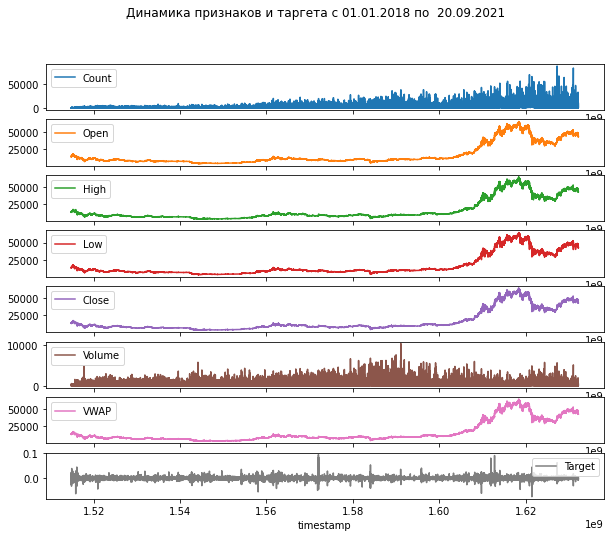

In [ ]:
btc_data.drop('Asset_ID', axis=1).plot(subplots=True, figsize=(10,8), title = 'Динамика признаков и таргета с 01.01.2018 по  20.09.2021');

Проверим гранулярность временных рядов. основной интервал- это 60 мин, но существуют пропуски в данных. Заполним гэпы по времени предыдущими валидными значениями.

In [ ]:
(btc_data.index[1:]-btc_data.index[:-1]).value_counts() #гранулярность

60      1955857
120          59
180          14
360           5
600           5
240           5
420           4
300           3
900           3
720           3
540           3
660           2
1020          1
2880          1
1440          1
8700          1
3300          1
3000          1
1200          1
780           1
480           1
4500          1
4680          1
2040          1
4020          1
1140          1
Name: timestamp, dtype: int64

In [ ]:
btc_data = btc_data.reindex(range(btc_data.index[0],btc_data.index[-1]+60,60),method='pad')
(btc_data.index[1:]-btc_data.index[:-1]).value_counts()

60    1956943
Name: timestamp, dtype: int64

Рассмотрим показатели при помощи одного из популярных рыночных технических индикаторов- японских свечей, визуально дающих полную информацию за тик. (График вида «японские свечи» также называют совмещением интервального и линейного графика в том смысле, что каждый его элемент отображает диапазон изменения цены в течение определённого времени.)

In [ ]:
btc_mini = btc_data.iloc[-200:]
fig = go.Figure(data=[go.Candlestick(x=btc_mini.index, open=btc_mini['Open'], high=btc_mini['High'], low=btc_mini['Low'], close=btc_mini['Close'])],\
                layout=go.Layout(
        title=go.layout.Title(text="Японские свечи - динамика последних трех часов")))
fig.show()

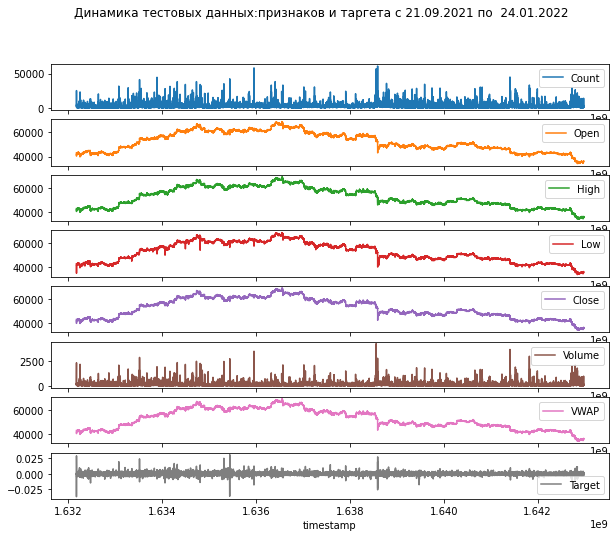

In [ ]:
#тестовые данные
btc_data_suppl.drop('Asset_ID', axis=1).plot(subplots=True, figsize=(10,8), title = 'Динамика тестовых данных:признаков и таргета с 21.09.2021 по  24.01.2022');

In [ ]:
(btc_data_suppl.index[1:]-btc_data_suppl.index[:-1]).value_counts() #гранулярность теста

60     179975
120         4
Name: timestamp, dtype: int64

In [ ]:
btc_data_suppl = btc_data_suppl.reindex(range(btc_data_suppl.index[0],btc_data_suppl.index[-1]+60,60),method='pad')
(btc_data_suppl.index[1:]-btc_data_suppl.index[:-1]).value_counts()

60    179983
Name: timestamp, dtype: int64

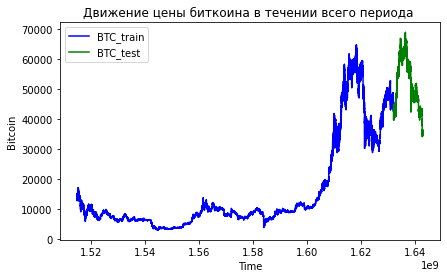

In [ ]:
f = plt.figure(figsize=(15,4))
ax = f.add_subplot(121)
# ax1 = ax.twinx()
ax.plot(btc_data['Close'], label='BTC_train', color='b' )
ax.plot(btc_data_suppl['Close'], label='BTC_test', color='g')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')
plt.title('Движение цены биткоина в течении всего периода ');

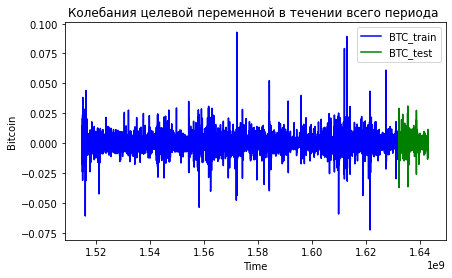

In [ ]:
f = plt.figure(figsize=(15,4))
ax = f.add_subplot(121)
# ax1 = ax.twinx()
ax.plot(btc_data['Target'], label='BTC_train', color='b' )
ax.plot(btc_data_suppl['Target'], label='BTC_test', color='g')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')
plt.title('Колебания целевой переменной в течении всего периода ');

Сильные всплески доходности говорят о высокой волатильности рынка внутри дня, но при этом,  в обучаемой части, при низких объемах торгов- говорят о слабости и неразвитости рынка в этот период. Тестовая , более поздняя часть, сохранила высокую ценовую волатильность, но по доходности в разрезе тайм-лага 15 мин, выглядит более стабильно. Таким образом. обучаемая часть датасета относится к развивающемуся рынку криптовалют.

In [ ]:
btc_data_suppl.drop('Asset_ID', axis=1, inplace= True)
btc_data.drop('Asset_ID', axis=1, inplace= True)

In [ ]:
btc_data.corrwith(btc_data['Target']).abs().sort_values(ascending=False)

Target    1.000000
Volume    0.014281
High      0.008530
Close     0.008529
VWAP      0.008520
Open      0.008510
Low       0.008509
Count     0.005533
dtype: float64

In [ ]:
btc_data.corr().style.background_gradient(sns.light_palette('blue', as_cmap=True))

,Count,Open,High,Low,Close,Volume,VWAP,Target
Count,1.000000,0.523038,0.523949,0.521957,0.523002,0.672758,0.522991,-0.005533
Open,0.523038,1.000000,0.999995,0.999995,0.999998,0.044190,0.999999,-0.008510
High,0.523949,0.999995,1.000000,0.999985,0.999995,0.044935,0.999995,-0.008530
Low,0.521957,0.999995,0.999985,1.000000,0.999995,0.043258,0.999996,-0.008509
Close,0.523002,0.999998,0.999995,0.999995,1.000000,0.044147,1.000000,-0.008529
Volume,0.672758,0.044190,0.044935,0.043258,0.044147,1.000000,0.044140,0.014281
VWAP,0.522991,0.999999,0.999995,0.999996,1.000000,0.044140,1.000000,-0.008520
Target,-0.005533,-0.008510,-0.008530,-0.008509,-0.008529,0.014281,-0.008520,1.000000


Все признаки сильно взаимосвязаны между собой, но с целевой переменной коррелируют, однако, мало. Наибольшую корреляцию показывает объем торгов. Что вполне объяснимо , учитывая характер целевой переменной.  Давайте приведем наши признаки к рассчитанным, рынок давно использует большое количество технических индикаторов, самое простое в данной ситуации - воспользоваться аналогией с  японскими свечами.

# 3.Подготовка данных

Делить датасеты на обучаемую ивалидационную части будем по дате, чтобы сохранить целостность по дням.

In [ ]:
split_date = '2021-01-01 00:01:00'
split_idx = np.datetime64(split_date).astype('int')

##Наборы датасетов

Создадим два датасета для тестирования. Наш первый датасет будет аутентичен первоначальным данным.

### 1 data set

In [ ]:
data1 = btc_data.copy()
data1_train, data1_val = data1.loc[:split_idx], data1.loc[split_idx:]
data1_test = btc_data_suppl.copy()

посмотрим на признаки используя  [Dickey–Fuller test](https://)

In [ ]:
for name, values in data1_test.iteritems():
    st = adfuller(values[:10000])[1]
    print(f'{name}: {st}')

Count: 2.1737924817708445e-19
Open: 0.015826130432194177
High: 0.01867347980325394
Low: 0.01289183426469766
Close: 0.017457230576952573
Volume: 2.225077698321021e-19
VWAP: 0.01584460726781298
Target: 1.2985949428171652e-28


В итоге, валидационная часть, которую мы будем использовать для подбора параметров, составила 24% от всей выборки.

In [ ]:
round(len(data1_val)/len(data1_train),2)

0.24

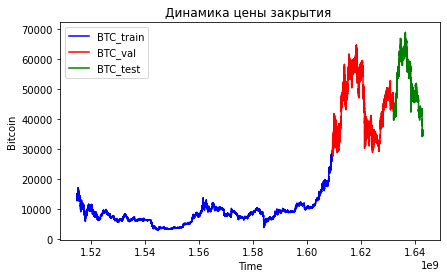

In [ ]:
f = plt.figure(figsize=(15,4))
ax = f.add_subplot(121)
ax.plot(data1_train['Close'], label='BTC_train', color='b' )
ax.plot(data1_val['Close'], label='BTC_val', color='r')
ax.plot(data1_test['Close'], label='BTC_test', color='g')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bitcoin')
plt.title('Динамика цены закрытия ');

### 2 data set

In [ ]:
def body_size(df): 
    return (df['Close'] - df['Open'])
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']
def log_return(series, periods=None):
    return np.log(series).diff(periods).fillna(0)

In [ ]:
def get_data2(df):
    df2 = df[['Count', 'Volume','Target']].copy()
    df2['Upper_Shadow'] = upper_shadow(df)
    df2['Body_Size'] = body_size(df)
    df2['Lower_Shadow'] = lower_shadow(df)
    df2['VWAP_1'] = log_return(df['VWAP'], 1)
    df2['VWAP_5'] = log_return(df['VWAP'], 5)
    return df2

In [ ]:
data2 = get_data2(data1)
data2_train, data2_val = data2.loc[:split_idx], data2.loc[split_idx:]
data2_test = get_data2(data1_test)

In [ ]:
for name, values in data2_test.iteritems():
    st = adfuller(values[:10000])[1]
    print(f'{name}: {st}')

Count: 2.1737924817708445e-19
Volume: 2.225077698321021e-19
Target: 1.2985949428171652e-28
Upper_Shadow: 5.61207247439323e-23
Body_Size: 2.0378277177863136e-30
Lower_Shadow: 0.0
VWAP_1: 3.14055293216047e-30
VWAP_5: 7.28627628891341e-29


можем сказать, что в результате преобразования признаков в показатели японских свечей мы избавились от их стационарности. Для преобразования средневзвешенной цены использовали логарифмирование и дифференцирование временного ряда с лагом  1 и 5 минут.

In [ ]:
data2.corr().style.background_gradient(sns.light_palette('blue', as_cmap=True))

,Count,Volume,Target,Upper_Shadow,Body_Size,Lower_Shadow,VWAP_1,VWAP_5
Count,1.000000,0.672758,-0.005533,0.243561,-0.019625,0.362646,-0.035435,-0.054194
Volume,0.672758,1.000000,0.014281,0.168054,-0.024697,0.234404,-0.058691,-0.072535
Target,-0.005533,0.014281,1.000000,-0.003670,-0.011066,-0.004656,-0.024393,-0.030469
Upper_Shadow,0.243561,0.168054,-0.003670,1.000000,0.032960,0.554040,0.043521,0.001988
Body_Size,-0.019625,-0.024697,-0.011066,0.032960,1.000000,-0.052081,0.453391,0.194468
Lower_Shadow,0.362646,0.234404,-0.004656,0.554040,-0.052081,1.000000,-0.064277,-0.058569
VWAP_1,-0.035435,-0.058691,-0.024393,0.043521,0.453391,-0.064277,1.000000,0.452294
VWAP_5,-0.054194,-0.072535,-0.030469,0.001988,0.194468,-0.058569,0.452294,1.000000


Уменьшился и уровень корреляции между признаками, а также мы можем говорить , что наши признаки теперь не мультиколлинеарны: все коэффициенты vif ниже range(5,10)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = [variance_inflation_factor(data2.drop(['Target'], axis=1).values, i) for i in range(data2.drop(['Target'], axis=1).shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=data2.drop(['Target'], axis=1).columns).T

,Count,Volume,Upper_Shadow,Body_Size,Lower_Shadow,VWAP_1,VWAP_5
vif,2.832314,2.439963,2.093314,1.261453,2.253653,1.531584,1.260137


выделим таргет

In [ ]:
def split_target(df):
    X_train = df.drop('Target', axis = 1)
    y_train = df['Target']
    return X_train, y_train

In [ ]:
X_train,y_train = split_target(data1)
X_test,y_test = split_target(data1_test)

Рассчитаем взвешенную корреляцию , используемую при оценке kaggle,  для сравнения с нашей метрикой. 

In [ ]:
index_value = assets.index[assets['Asset_ID']==1][0]
w = assets.loc[index_value,'Weight' ]
def m(x, w):
    """Взвешенное среднее"""
    return np.sum(x * w) / np.sum(w)
def cov(x, y, w):
    """Взвешенная ковариация"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)
def corr(x, y, w):
    """Взвешенная корреляция"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))
weight_array = np.array([w for i in range(len(X_test))])  

Зафиксируем случайные состояния.

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random_state= 555

# 4.Моделирование

##Linear Regression 

In [ ]:
%%time
X_train,y_train = split_target(data2)
X_test,y_test = split_target(data2_test)
pipe22 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())])
pipe22.fit(X_train,y_train)
y_test_predict_lr = pipe22.predict(X_test)
print('Test score for LR baseline: MSE_test', f": {mean_squared_error(y_test, y_test_predict_lr):.6f},")
print('Corrcoef: BTC_test', f"{np.corrcoef(y_test_predict_lr, y_test)[0,1]:.6f}",
      ', Corrcoef_weighted BTC_test',f"{corr(pipe22.predict(X_test), y_test, weight_array):.6f}"
      ', BTC_train', f"{np.corrcoef(pipe22.predict(X_train), y_train)[0,1]:.6f}"
            )

Test score for LR baseline: MSE_test : 0.000003,
Corrcoef: BTC_test 0.029550 , Corrcoef_weighted BTC_test 0.029557, BTC_train 0.040625
CPU times: user 1.37 s, sys: 581 ms, total: 1.95 s
Wall time: 3.17 s


Взвешенный коффициент корреляции не отличается до 6 цифры после запятой от невзешенного, поэтому далее его вычисление пока опустим. 

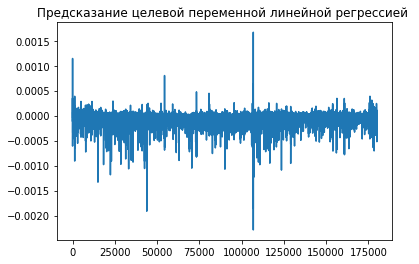

In [ ]:
#LR
fig, ax = plt.subplots()
ax.plot(y_test_predict_lr)
plt.title('Предсказание целевой переменной линейной регрессией ');

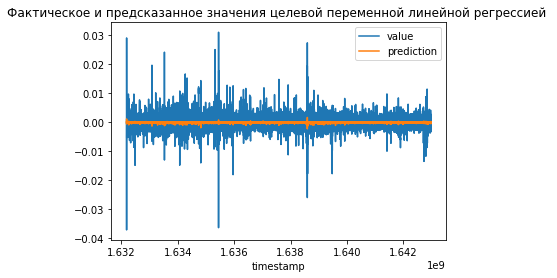

In [ ]:
pd.DataFrame(data={"value": y_test, "prediction": y_test_predict_lr}, index=X_test.head(len(y_test)).index).plot()
plt.title('Фактическое и предсказанное значения целевой переменной линейной регрессией ');

##Linear Polynomial Regression

Алгоритм «Polynomial Features», предоставляемый Scikit-Learn, при передаче нных обучающих данных, добавляет квадрат всех функций, присутствующих в наших обучающих данных, в качестве новых функций для нашей модели. Когда у нас есть несколько функций, полиномиальная регрессия способна найти отношения между всеми функциями в данных. Это возможно, потому что полиномиальные функции добавляют все комбинации функций в определенной степени.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, include_bias=False)

In [ ]:
%%time
X_train,y_train = split_target(data2)
X_test,y_test = split_target(data2_test)
pipe31 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())])
pipe31.fit(X_train,y_train)
y_test_predict_lr_poly = pipe31.predict(X_test)
print('Test score for LR_poly baseline: MSE_test', f": {mean_squared_error(y_test, y_test_predict_lr_poly):.9f}")
print('Corrcoef: BTC_test', f"{np.corrcoef(y_test_predict_lr_poly, y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(pipe31.predict(X_train), y_train)[0,1]:.6f}")

Test score for LR_poly baseline: MSE_test : 0.000002523
Corrcoef: BTC_test 0.031274 , BTC_train 0.059064
CPU times: user 10.5 s, sys: 3.85 s, total: 14.3 s
Wall time: 12.3 s


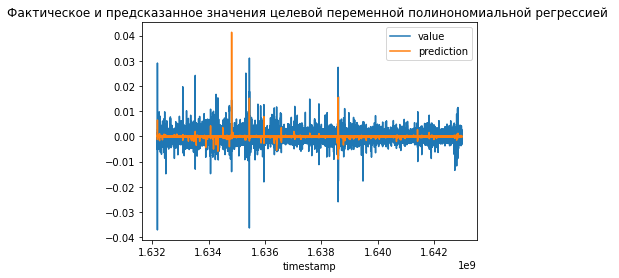

In [ ]:
pd.DataFrame(data={"value": y_test, "prediction": y_test_predict_lr_poly}, index=X_test.head(len(y_test)).index).plot()
plt.title('Фактическое и предсказанное значения целевой переменной полинономиальной регрессией ');

На данный момент метод линейной регрессии с использованием полиномиальных признаков оказался наиболее эффективным, будем отталкиваться от этих результатов.

##Ridge Polynomial Regression

In [ ]:
%%time
X_train,y_train = split_target(data2)
X_test,y_test = split_target(data2_test)

cv = RepeatedKFold(n_splits= 10 , n_repeats= 3 , random_state= random_state )

pipe122 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV(alphas= ( 1, 10.0, 50.0), cv=cv, scoring='neg_mean_squared_error'))])
pipe122.fit(X_train,y_train)

y_test_predict_ridge = pipe122.predict(X_test)

print('Best CV_score for ridge baseline: MSE', f": {pipe122.named_steps['regressor'].best_score_:.6f}",
      ',Test score for ridge baseline: MSE_test', f": {mean_squared_error(y_test, y_test_predict_ridge):.6f}")
print('Corrcoef: BTC_test', f"{np.corrcoef(y_test_predict_ridge, y_test)[0,1]:.6f}",
      ', Corrcoef_weighted BTC_test',f"{corr(pipe122.predict(X_test), y_test, weight_array):.6f}"
      ', BTC_train', f"{np.corrcoef(pipe122.predict(X_train), y_train)[0,1]:.6f}" )

Best CV_score for ridge baseline: MSE : -0.000004 ,Test score for ridge baseline: MSE_test : 0.000003
Corrcoef: BTC_test 0.031277 , Corrcoef_weighted BTC_test 0.031281, BTC_train 0.059064
CPU times: user 1min 25s, sys: 28.6 s, total: 1min 54s
Wall time: 1min 49s


Получили чуть выше результат, чем в предыдущей модели

In [ ]:
pipe122.named_steps['regressor'].alpha_

50.0

In [ ]:
%%time
X_train,y_train = split_target(data2)
X_test,y_test = split_target(data2_test)

pipe122 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV(alphas= (50.0)))])
pipe122.fit(X_train,y_train)

CPU times: user 17.1 s, sys: 3.62 s, total: 20.7 s
Wall time: 15.5 s


Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('regressor', RidgeCV(alphas=50.0))])

##K-Nearest Neighbors Regression

Чтобы предсказать новую точку данных, алгоритм K-ближайших соседей (KNN) находит точку в обучающем наборе, которая находится ближе всего к новой точке. Затем, в случае использования метода для регрессии, точке присваивается среднее значение по k ближайшим к нему объектам, значения которых уже известны. Алгоритм может быть применим к выборкам с большим количеством атрибутов. Расстояния могут сильно зависеть от атрибутов с бо́льшими диапазонами. Поэтому данные обычно подлежат нормализации. 

In [ ]:
%%time
pipe51 = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', KNeighborsRegressor())])
X_train,y_train = split_target(data2)
X_test,y_test = split_target(data2_test)
pipe51.fit(X_train,y_train)
y_test_predict_knn = pipe51.predict(X_test)
print('Test score for KNeighbors baseline: MSE_test', f": {mean_squared_error(y_test, y_test_predict_knn):.9f}")
print('corrcoef: BTC_test', f"{np.corrcoef(y_test_predict_knn, y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(pipe51.predict(X_train), y_train)[0,1]:.6f}")

Test score for KNeighbors baseline: MSE_test : 0.000003517
corrcoef: BTC_test 0.002634 , BTC_train 0.466904
CPU times: user 9min 52s, sys: 1.68 s, total: 9min 53s
Wall time: 10min 7s


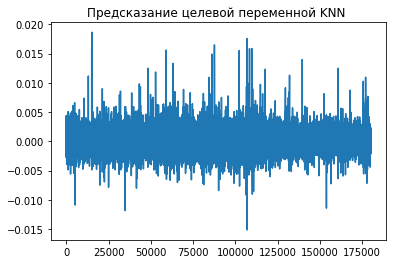

In [ ]:
# knn 
fig, ax = plt.subplots()
ax.plot(y_test_predict_knn)
plt.title('Предсказание целевой переменной KNN ');

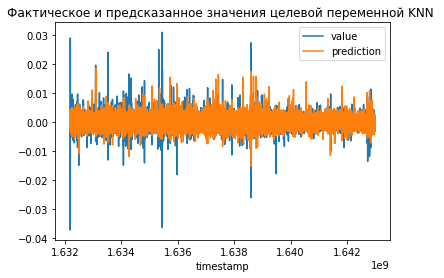

In [ ]:
pd.DataFrame(data={"value": y_test, "prediction": y_test_predict_knn}, index=X_test.head(len(y_test)).index).plot()
plt.title('Фактическое и предсказанное значения целевой переменной KNN ');

Коэффициент корреляции ниже все же, чем LR

##Decision Tree

Решающее дерево предсказывает значение целевой переменной с помощью применения последовательности простых решающих правил (которые называются предикатами). Этот процесс в некотором смысле согласуется с естественным для человека процессом принятия решений.Одним из многих качеств деревьев решений является то, что они не требуют подготовки данных. Фактически, они вообще не требуют масштабирования или нормализации элементов.

In [ ]:
%%time
pipe41 = Pipeline([
    ('scaler', None),
    ('regressor', DecisionTreeRegressor(random_state=random_state))])
X_train,y_train = split_target(data1)
X_test,y_test = split_target(data1_test)
pipe41.fit(X_train,y_train)
y_test_predict_dt = pipe41.predict(X_test)
print('Test score for DecisionTree baseline: MSE_test', f": {mean_squared_error(y_test, y_test_predict_dt):.9f}")
print('Сorrcoef: BTC_test', f"{np.corrcoef(y_test_predict_dt, y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(pipe41.predict(X_train), y_train)[0,1]:.6f}")

Test score for DecisionTree baseline: MSE_test : 0.000006249
Сorrcoef: BTC_test 0.004804 , BTC_train 1.000000
CPU times: user 1min 24s, sys: 583 ms, total: 1min 25s
Wall time: 1min 26s


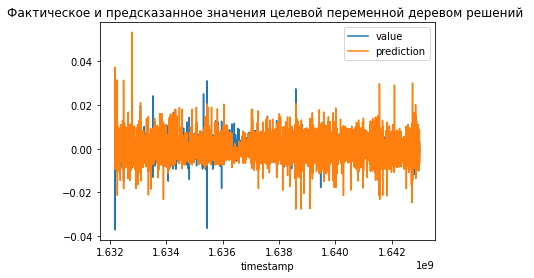

In [ ]:
pd.DataFrame(data={"value": y_test, "prediction": y_test_predict_dt}, index=X_test.head(len(y_test)).index).plot()
plt.title('Фактическое и предсказанное значения целевой переменной деревом решений ');

Дерево решений способно идеально приблизить обучающую выборку и ничего не выучить (то есть такой классификатор будет обладать низкой обобщающей способностью): для этого достаточно построить такое дерево, в каждый лист которого будет попадать только один объект,что мы и видим в нашем примере : множество ложных сигналов. <br>Следовательно, при обучении нам надо не просто приближать обучающую выборку как можно лучше, но и стремиться оставлять дерево как можно более простым, чтобы результат обладал хорошей обобщающей способностью. Подберем ограничивающие параметры глубины дерева, минимального числа объектов в листе с помощью RandomizedSearchCV, проводя параллельно кросс-валидацию.

In [ ]:
print(pipe41.named_steps['regressor'].get_params() )

{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 555, 'splitter': 'best'}


In [ ]:
%%time
RS_dt = RandomizedSearchCV(
            estimator=DecisionTreeRegressor(random_state=random_state) ,         
            param_distributions = {                
              "min_samples_split": [2, 10, 20],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [1, 20, 50],
              "max_leaf_nodes": [2, 5, 20]
            },
            scoring = 'neg_mean_squared_error',    
            cv = 5,                                
            n_jobs = -1,                           
            random_state=random_state ,
            return_train_score=True,
            n_iter=20,                             
            verbose = 0    )


RS_dt.fit(X_train,y_train)

CPU times: user 7.28 s, sys: 664 ms, total: 7.95 s
Wall time: 7min 9s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=555),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [2, 6, 8],
                                        'max_leaf_nodes': [2, 5, 20],
                                        'min_samples_leaf': [1, 20, 50],
                                        'min_samples_split': [2, 10, 20]},
                   random_state=555, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [ ]:
print("The best_params:\n{}\n".format(RS_dt.best_params_), 
        "The best MSE_cv score: {:.9f}".format(-RS_dt.best_score_))
print('Test score for DecisionTree baseline: MSE_test', f": {mean_squared_error(y_test, RS_dt.predict(X_test)):.9f}",
      ', Сorrcoef: BTC_test', f"{np.corrcoef(RS_dt.predict(X_test), y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(RS_dt.predict(X_train), y_train)[0,1]:.6f}")

The best_params:
{'min_samples_split': 10, 'min_samples_leaf': 20, 'max_leaf_nodes': 2, 'max_depth': 6}
 The best MSE_cv score: 0.000004058
Test score for DecisionTree baseline: MSE_test : 0.000002519 , Сorrcoef: BTC_test -0.015986 , BTC_train 0.032510


В итоге мы ушли от переобучения, но получили отрицательную корреляцию, что совсем не соответствует ожиданиям.

##Ensemble Methods

Мета-алгоритм объединяет результаты работы других алгоритмов и принимает итоговое решение.<br>Бэггинг (от англ. bootstrap aggregating, бутстрэп-агрегирование) — ансамблевый метаалгоритм, предназначенный для улучшения стабильности и точности алгоритмов машинного обучения, используемых в задачах классификации и регрессии. Алгоритм также уменьшает дисперсию и помогает избежать переобучения. Хотя он обычно применяется к методам машинного обучения на основе деревьев решений, его можно использовать с любым видом метода. Бэггинг является частным видом усреднения модели.

##Bagging Regressor

Бэггинг-ансамбль линейной регрессии показал себя слегка хуже, чем просто LR:

In [ ]:
%%time
from sklearn.ensemble import BaggingRegressor
pipe71 = Pipeline([
    # ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', BaggingRegressor(LinearRegression(), n_estimators=10, random_state=random_state))])
X_train,y_train = split_target(data2)
X_test,y_test = split_target(data2_test)
pipe71.fit(X_train,y_train)
y_test_predict_bagg = pipe71.predict(X_test)
print('Test score for BaggingLinearRegressor baseline: MSE_test', f": {mean_squared_error(y_test, y_test_predict_bagg):.9f}")
print('corrcoef: BTC_test', f"{np.corrcoef(y_test_predict_bagg, y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(pipe71.predict(X_train), y_train)[0,1]:.6f}")

Test score for BaggingLinearRegressor baseline: MSE_test : 0.000002513
corrcoef: BTC_test 0.029315 , BTC_train 0.040595
CPU times: user 7.75 s, sys: 3.71 s, total: 11.5 s
Wall time: 10.2 s


##Stacking Regressor

Стекинг — обучение нескольких разных алгоритмов и передача их результатов на вход последнему.Финальное решение мета-алгоритм принимает, опираясь на результаты базовых алгоритмов.

Стекинг в сновном, усреднил показатели используемых алгоритмов:

In [ ]:
%%time
from sklearn.ensemble import StackingRegressor
estimators = [
     ('LR', LinearRegression()),
     ('Ridge', RidgeCV()),
     ("KNN", KNeighborsRegressor())]
pipe81 = Pipeline([
    # ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', StackingRegressor(estimators=estimators, final_estimator=RidgeCV()))])
X_train,y_train = split_target(data2)
X_test,y_test = split_target(data2_test)
pipe81.fit(X_train,y_train)
y_test_predict_stack = pipe81.predict(X_test)
print('Test score for StackingRegressor baseline: MSE_test', f": {mean_squared_error(y_test, y_test_predict_stack):.9f}")
print('corrcoef: BTC_test', f"{np.corrcoef(y_test_predict_stack, y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(pipe81.predict(X_train), y_train)[0,1]:.6f}")

Test score for StackingRegressor baseline: MSE_test : 0.000002512
corrcoef: BTC_test 0.019138 , BTC_train 0.334219
CPU times: user 25min 33s, sys: 13.9 s, total: 25min 47s
Wall time: 26min 58s


Стекинг линейных моделей чуть незначительно улучшил mse оценку:

In [ ]:
%%time
estimators = [
     ('LR', LinearRegression()),
     ('Ridge', RidgeCV())]
pipe91 = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('regressor', StackingRegressor(estimators=estimators, final_estimator=LinearRegression()))])
X_train,y_train = split_target(data2)
X_test,y_test = split_target(data2_test)
pipe91.fit(X_train,y_train)
y_test_predict_stack_ = pipe91.predict(X_test)
print('Test score for StackingRegressorLinear baseline: MSE_test', f": {mean_squared_error(y_test, y_test_predict_stack_):.9f}")
print('corrcoef: BTC_test', f"{np.corrcoef(y_test_predict_stack_, y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(pipe91.predict(X_train), y_train)[0,1]:.6f}")

Test score for StackingRegressorLinear baseline: MSE_test : 0.000002511
corrcoef: BTC_test 0.031274 , BTC_train 0.059064
CPU times: user 2min 5s, sys: 31 s, total: 2min 36s
Wall time: 2min 5s


##LightGBM

Light Gradient Boosted Machine (LightGBM) — это эффективная реализацию ансамбля стохастического градиентного бустинга. Градиентный бустинг относится к классу ансамблевых алгоритмов машинного обучения. Ансамбли строятся на основе моделей дерева решений. Деревья добавляются по одному в ансамбль и обучаются для исправления ошибок прогнозирования, сделанных предыдущими моделями.(бустинг)
Модели обучаются с использованием любой произвольной дифференцируемой функции потерь и алгоритма оптимизации градиентного спуска. Это даёт методу его название «градиентный бустинг», поскольку градиент потерь минимизируется по мере обучения модели, подобно нейронной сети. <br>LightGBM известен своей более высокой скоростью обучения, хорошей точностью с параметрами по умолчанию, параллельным и GPU обучением, малым использованием памяти и возможностью обработки больших датасетов, которые не всегда помещаются в ней.

In [ ]:
%%time
X_train,y_train = split_target(data1)
X_test,y_test = split_target(data1_test)
RS_lgb = RandomizedSearchCV(
            estimator=lgb.LGBMRegressor(random_state=random_state) ,         
            param_distributions = {                
              'num_leaves':[20,40,60,80,100], 
              'min_child_samples':[5,10,15],
              'max_depth':[2,5,10,20],
              'learning_rate':[0.05,0.1,0.15, 0.2],
              'reg_alpha':[0,0.01,0.03]
            },
            scoring = 'neg_mean_squared_error',    
            cv = 5,                                
            n_jobs = -1,                           
            random_state=random_state ,
            return_train_score=True,
            n_iter=5,                             
            verbose =0     )


RS_lgb.fit(X_train,y_train)

CPU times: user 9.49 s, sys: 496 ms, total: 9.99 s
Wall time: 4min 36s


RandomizedSearchCV(cv=5, estimator=LGBMRegressor(random_state=555), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 5, 10, 20],
                                        'min_child_samples': [5, 10, 15],
                                        'num_leaves': [20, 40, 60, 80, 100],
                                        'reg_alpha': [0, 0.01, 0.03]},
                   random_state=555, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [ ]:
print("The best_params:\n{}\n".format(RS_lgb.best_params_), 
        "The best MSE_cv score: {:.9f}".format(-RS_lgb.best_score_))
print('Test score for LGBM baseline: MSE_test', f": {mean_squared_error(y_test, RS_lgb.predict(X_test)):.9f}",
      ', corrcoef: BTC_test', f"{np.corrcoef(RS_lgb.predict(X_test), y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(RS_lgb.predict(X_train), y_train)[0,1]:.6f}")

The best_params:
{'reg_alpha': 0, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 2, 'learning_rate': 0.05}
 The best MSE_cv score: 0.000004057
Test score for LGBM baseline: MSE_test : 0.000002521 , corrcoef: BTC_test 0.010246 , BTC_train 0.043558


In [ ]:
%%time
pipe_lgb = Pipeline([
    ('scaler', None),
    ('regressor', lgb.LGBMRegressor(reg_alpha= 0, num_leaves= 40, min_child_samples= 15, max_depth= 2,
                                    learning_rate= 0.05,random_state=random_state))])
X_train,y_train = split_target(data1)
X_test,y_test = split_target(data1_test)
pipe_lgb.fit(X_train,y_train)
y_test_predict_lgb = pipe_lgb.predict(X_test)
print('Test score for LGBM baseline: MSE_test', f": {mean_squared_error(y_test, y_test_predict_lgb):.9f}")
print('corrcoef: BTC_test', f"{np.corrcoef(y_test_predict_lgb, y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(pipe_lgb.predict(X_train), y_train)[0,1]:.6f}")

Test score for LGBM baseline: MSE_test : 0.000002521
corrcoef: BTC_test 0.010246 , BTC_train 0.043558
CPU times: user 20.8 s, sys: 121 ms, total: 20.9 s
Wall time: 12.2 s


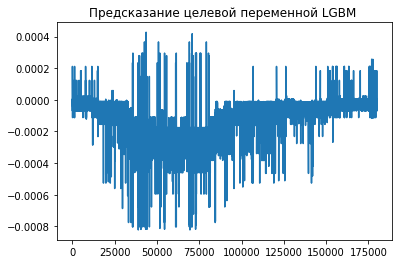

In [ ]:
#lgb
fig, ax = plt.subplots()
ax.plot(y_test_predict_lgb)
plt.title('Предсказание целевой переменной LGBM ');

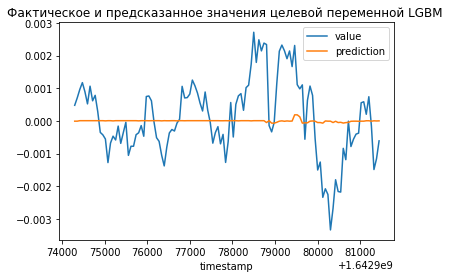

In [ ]:
pd.DataFrame(data={"value": y_test, "prediction": y_test_predict_lgb}, index=X_test.head(len(y_test)).index).iloc[-120:].plot()
plt.title('Фактическое и предсказанное значения целевой переменной LGBM ');

In [ ]:
%%time
X_train,y_train = split_target(data2)
X_test,y_test = split_target(data2_test)
RS_lgb2 = RandomizedSearchCV(
            estimator=lgb.LGBMRegressor(random_state=random_state) ,         
            param_distributions = {                
              'num_leaves':[20,40,60,80,100], 
              'min_child_samples':[5,10,15],
              'max_depth':[2,5,10,20],
              'learning_rate':[0.05,0.1,0.15, 0.2],
              'reg_alpha':[0,0.01,0.03]
            },
            scoring = 'neg_mean_squared_error',    
            cv = 5,                                
            n_jobs = -1,                           
            random_state=random_state ,
            return_train_score=True,
            n_iter=5,                             
            verbose = 0    )


RS_lgb2.fit(X_train,y_train)
print("The best_params:\n{}\n".format(RS_lgb2.best_params_), 
      "The best MSE_cv score: {:.9f}".format(-RS_lgb2.best_score_))
print('Test score for LGB2 baseline: MSE_test', f": {mean_squared_error(y_test, RS_lgb2.predict(X_test)):.9f}",
      ', corrcoef: BTC_test', f"{np.corrcoef(RS_lgb2.predict(X_test), y_test)[0,1]:.6f}",
      ', BTC_train', f"{np.corrcoef(RS_lgb2.predict(X_train), y_train)[0,1]:.6f}")

The best_params:
{'reg_alpha': 0, 'num_leaves': 40, 'min_child_samples': 15, 'max_depth': 2, 'learning_rate': 0.05}
 The best MSE_cv score: 0.000004073
Test score for LGBM baseline: MSE_test : 0.000002519 , corrcoef: BTC_test -0.009757 , BTC_train 0.056588
Wall time: 1min 37s


Градиентный бустинг LGBM показал 1)лучше результаты на необработанном датасете, 2) лучше результаты, чем Решающие деревья, KNN и RandomForest. Но уступил линейным методам.

In [ ]:
explainer_reg = shap.TreeExplainer(RS_lgb.best_estimator_)
shap_values_reg = explainer_reg.shap_values(X_train)


auto_size_plot=False is deprecated and is now ignored! Use plot_size=None instead.


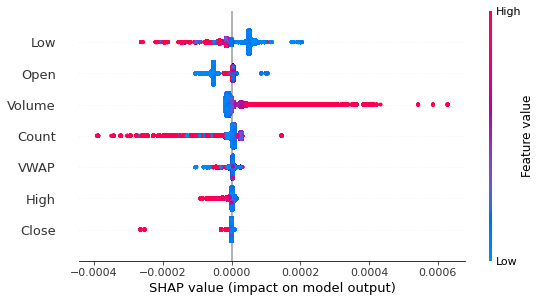

In [ ]:
shap.summary_plot(shap_values_reg, X_train, max_display=25, auto_size_plot=True) #Use plot_size=None instead

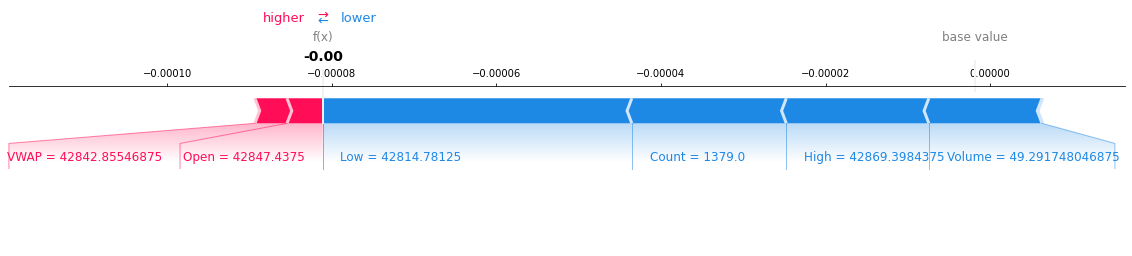

In [ ]:
shap.force_plot(explainer_reg.expected_value, shap_values_reg[0], X_test.iloc[[170000]], matplotlib = True)

##GRU

GRU(Gated Recurrent Unit) - сеть  из семьи рекуррентных нейронных сетей(RNN). Фактически является пересмотром архитектуры LSTM в
сторону ее упрощения. В ней входной узел и узел забвения объединены
в один узел - узел обновления (update gate), также еще есть несколько изменений во внутренней архитектуре. GRU модуль можно описать
следующими формулами: [на сайт Pytorch](https://). К основным плюсам GRU по сравнению с LSTM относится более быстрое обучение, так как архитектура GRU проще, и, как следствие там меньше различных операций. При этом GRU сети могут работать иногда лучше LSTM на тех же данных.<br> Ссылки по модели:
[Иллюстрированное руководство по LSTM и GRU: пошаговое объяснение](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21),<br>[Gated Recurent Unit (GRU) с PyTorch](https://blog.floydhub.com/gru-with-pytorch/)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


###Создание датасета

In [ ]:
X_train,y_train = split_target(data1_train)       #1 датасет 
X_val,y_val = split_target(data1_val)
X_test,y_test = split_target(data1_test)

In [ ]:
X_train,y_train = split_target(data2_train)        #2 датасет
X_val,y_val = split_target(data2_val)
X_test,y_test = split_target(data2_test)

Масштабирование признаков в наборе данных является настоятельно рекомендуемой практикой для нейронных сетей, как и для многих других методов машинного обучения. Это ускоряет обучение, облегчая модели обновление весов.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_msc = scaler.fit_transform(X_train)
X_val_msc = scaler.transform(X_val)
X_test_msc = scaler.transform(X_test)

In [ ]:
scaler = StandardScaler()
X_train_msc = scaler.fit_transform(X_train)
X_val_msc = scaler.transform(X_val)
X_test_msc = scaler.transform(X_test)

In [ ]:
X_train_tns = torch.from_numpy(X_train_msc).type(torch.Tensor).to(device)
X_val_tns = torch.from_numpy(X_val_msc).type(torch.Tensor).to(device)
X_test_tns = torch.from_numpy(X_test_msc).type(torch.Tensor).to(device)

In [ ]:
y_train_tns = torch.Tensor(y_train.to_numpy()).to(device)
y_val_tns = torch.Tensor(y_val.to_numpy()).to(device)
y_test_tns = torch.Tensor(y_test.to_numpy()).to(device)

In [ ]:
train_TDset = TensorDataset(X_train_tns, y_train_tns)
val_TDset = TensorDataset(X_val_tns, y_val_tns)
test_TDset = TensorDataset(X_test_tns, y_test_tns)

Класс PyTorch DataLoader, дает итерируемый набор данных, загружает данные и разбивает их на пакеты, для выполнения мини-пакетного обучения. Существуют два типа наборов данных, один из которых представляет собой наборы данных в стиле карты (map-style), а другой — наборы данных в  iterable-style.

In [ ]:
batch_size = 128

In [ ]:
train_loader = DataLoader(train_TDset, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_TDset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_TDset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test_TDset, batch_size=1, shuffle=False, drop_last=True)

Поскольку PyTorch автоматически определяет back propagation, определяем параметры класса и метод forward.<br> Параметры:
input_dim (int): Число нод(узлов) во входящем слое, равно числу признаков<br> hidden_dim (int): Число скрытых нейронов<br>layer_dim (int):  Число слоев сети<br>output_dim (int): Число нейронов в исходящем слое. Для задачи регрессии- 1 <br>dropout_prob (float): Для избегания переобучения и предотвращения коадпатации нейронов будем случайно выключать нейроны (dropout) с заданной вероятностью.<br>Forward метод принимает входной тензор x и выполняет движение вперед(forward propagation), x - это входная матрица -тензор размерности (N,L,H_in) - (batch size, sequence length, input_size), Возвращает:
выходной тензор размерности (L,D∗Hout)  - (batch size, output_size). D=2 для bidirectional=True, иначе 1.<br> необходим метод detach(), так как мы делаем усеченное обратное распространение во времени (BPTT).( Если мы этого не сделаем, мы будем выполнять обратное распространение до самого начала, даже после прохождения еще одной партии)
         

        

###Модель

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout_prob):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob)   # слой GRU
        self.fc = nn.Linear(hidden_dim, output_dim)                                                    # полносвязный слой   

    def forward(self, x):                                                                              
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)       #инициализация скрытого слоя в виде нулевого тензора
        out, (hn) = self.gru(x, (h0.detach()))                                                          #проход матрицы признаков и скрытого слоя через слой GRU  
        out = self.fc(out[:, -1, :])                                                                    #перевод 2 мерного выхода в трехмерный для прохода в полносвязном слое  
       
        return out

В следующем классе мы объединили процедуры тренировки и оценки. Входящие параметры: model : класс модели, созданный для типа RNN.<br>criterion (torch.nn.modules.Loss): функция потерь для расчета потерь <br>optimizer (torch.optim.Optimizer): функция оптимизатора для оптимизации функции потерь<br>    train_losses (list[float]): значения потерь на тренировке<br>         val_losses (list[float]): значения потерь из проверки<br>n_epochs(int): количество эпох, в течение которых модели обучаются.<br>Метод train_step это один шаг обучения. Во-первых, он активирует режим train mode, чтобы включить back propagation.<br> После генерации прогнозируемых значений (yhat)режима forward вычисляется loss с помощью функции потерь. Затем вычисляются градиенты, выполняя обратное движение(back propagation), обновляя веса.

In [ ]:
class Optimization:
    def __init__(self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        self.model.train()                                                         #режим тренировки включен   
        yhat = self.model(x)                                                       #получаем предсказание    
        loss = self.criterion(y, yhat)                                             #рассчитываем ошибку 
        self.optimizer.zero_grad()                                                 #обнуляем веса 
        loss.backward()                                                            #обратное распространение ошибки с помощью метода backward() 
        self.optimizer.step()                                                      #делаем шаг оптимизатора и обновляем веса модели   
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=batch_size, n_epochs=10, n_features=1):
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)                                            #подсчитываем ошибку на батче
            training_loss = np.mean(batch_losses)                                    #аккумулируем ошибки 
            self.train_losses.append(training_loss)

            with torch.no_grad():                                                    #аналогично для валидационного сета, без обновления градиентов
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.criterion(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.9f}\t Validation loss: {validation_loss:.9f}"
                )
    def evaluate(self, test_loader, batch_size=1, n_features=1):                    
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach())
                values.append(y_test.to(device).detach())
        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()    

####train1

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/rnn.py:67: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



[1/10] Training loss: 0.000016372	 Validation loss: 0.000026559
[2/10] Training loss: 0.000004593	 Validation loss: 0.000020037
[3/10] Training loss: 0.000004372	 Validation loss: 0.000016753
[4/10] Training loss: 0.000004274	 Validation loss: 0.000014790
[5/10] Training loss: 0.000004218	 Validation loss: 0.000013549
[6/10] Training loss: 0.000004178	 Validation loss: 0.000012574
[7/10] Training loss: 0.000004145	 Validation loss: 0.000011625
[8/10] Training loss: 0.000004110	 Validation loss: 0.000010589
[9/10] Training loss: 0.000004075	 Validation loss: 0.000009530
[10/10] Training loss: 0.000004038	 Validation loss: 0.000008651


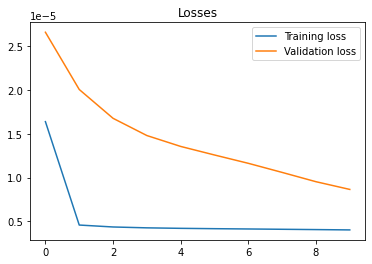

CPU times: user 7min 57s, sys: 6.61 s, total: 8min 4s
Wall time: 8min 43s


In [ ]:
%%time
input_dim = len(X_train.columns)          # train1(data2, mms)
output_dim = 1
hidden_dim = 3
num_layers = 1
batch_size = 128
dropout = 0.2
n_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'num_layers' : num_layers,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout_prob= dropout )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
if torch.cuda.is_available():
   model.cuda()
   

opt = Optimization(model=model, criterion=criterion, optimizer=optimizer)
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()


In [ ]:
%%time
predictions, values = opt.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)
predictions = torch.tensor(predictions).detach().cpu().numpy()
values = torch.tensor(values).detach().cpu().numpy()
print('Test score for gru baseline: MSE_test', f": {mean_squared_error(y_test, predictions):.9f}",
      ', corrcoef: BTC_test', f"{np.corrcoef(predictions, y_test)[0,1]:.6f}" )

Test score for gru baseline: MSE_test : 0.000004776 , corrcoef: BTC_test 0.007455
CPU times: user 1min 30s, sys: 611 ms, total: 1min 31s
Wall time: 1min 31s


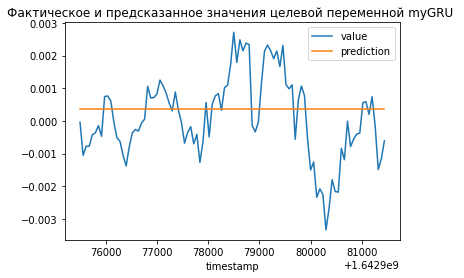

In [ ]:
df_result = pd.DataFrame(data={"value": values, "prediction": predictions}, index=X_test.head(len(values)).index)
df_result = df_result.sort_index()
df_result.iloc[-100:].plot()
plt.title('Фактическое и предсказанное значения целевой переменной myGRU ');

####train2

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning:

Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



[1/10] Training loss: 0.002682731	 Validation loss: 0.000006743
[2/10] Training loss: 0.000003916	 Validation loss: 0.000006430
[3/10] Training loss: 0.000003851	 Validation loss: 0.000006365
[4/10] Training loss: 0.000003841	 Validation loss: 0.000006318
[5/10] Training loss: 0.000003835	 Validation loss: 0.000006317
[6/10] Training loss: 0.000003834	 Validation loss: 0.000006282
[7/10] Training loss: 0.000003828	 Validation loss: 0.000006266
[8/10] Training loss: 0.000003826	 Validation loss: 0.000006260
[9/10] Training loss: 0.000003820	 Validation loss: 0.000006245
[10/10] Training loss: 0.000003817	 Validation loss: 0.000006244


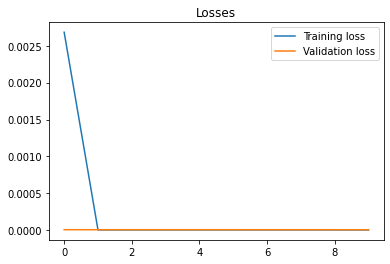

CPU times: user 8min 35s, sys: 5.92 s, total: 8min 41s
Wall time: 8min 50s


In [ ]:
%%time
input_dim = len(X_train.columns)              # train4(data1, ssc)+
output_dim = 1
hidden_dim = 3
num_layers = 2
batch_size = 128
dropout = 0.2
n_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'num_layers' : num_layers,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers, dropout_prob= dropout )
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
if torch.cuda.is_available():
   model.cuda()
   

opt2802 = Optimization(model=model, criterion=criterion, optimizer=optimizer)
opt2802.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt2802.plot_losses()


In [ ]:
predictions2802, values2802 = opt2802.evaluate(
    test_loader_one,
    batch_size=1,
    n_features=input_dim
)
predictions2802 = torch.tensor(predictions2802).detach().cpu().numpy()
values2802 = torch.tensor(values2802).detach().cpu().numpy()
print('Test score for GRU baseline: MSE_test', f": {mean_squared_error(y_test, predictions2802):.9f}",
      ', corrcoef: BTC_test', f"{np.corrcoef(predictions2802, y_test)[0,1]:.6f}" )

Test score for GRU baseline: MSE_test : 0.000002513 , corrcoef: BTC_test 0.013022


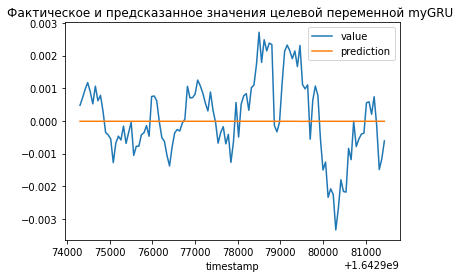

In [ ]:
df_result = pd.DataFrame(data={"value": values2802, "prediction": predictions2802}, index=X_test.head(len(values2802)).index)
df_result = df_result.sort_index()
df_result.iloc[-120:].plot()
plt.title('Фактическое и предсказанное значения целевой переменной myGRU ');

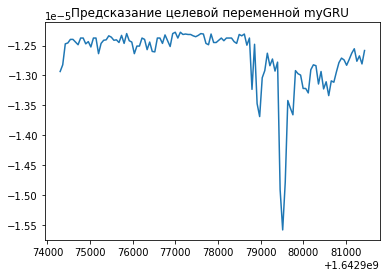

In [ ]:
fig, ax = plt.subplots()
ax.plot(df_result['prediction'].iloc[-120:])
plt.title('Предсказание целевой переменной myGRU ');

###сохраняем 1 модель

In [ ]:
from google.colab import files
# path = ! touch "/content/gdrive/My Drive"
torch.save(model.state_dict(),'checkpoint.pth')
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 GRU(
  (gru): GRU(7, 3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=3, out_features=1, bias=True)
) 

The state dict keys: 

 odict_keys(['gru.weight_ih_l0', 'gru.weight_hh_l0', 'gru.bias_ih_l0', 'gru.bias_hh_l0', 'fc.weight', 'fc.bias'])


In [ ]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
gru.weight_ih_l0 	 torch.Size([9, 7])
gru.weight_hh_l0 	 torch.Size([9, 3])
gru.bias_ih_l0 	 torch.Size([9])
gru.bias_hh_l0 	 torch.Size([9])
fc.weight 	 torch.Size([1, 3])
fc.bias 	 torch.Size([1])


#5.Итоговая оценка

In [ ]:
mod_lists = ['LR', 'poly_LR', 'poly_Ridge', 'KNN', 'DecisionTree', 'LGBM', 'myGRU']
results = [0.029550, 0.031274, 0.031281, 0.002634, 0.004804, 0.010246, 0.013022 ]

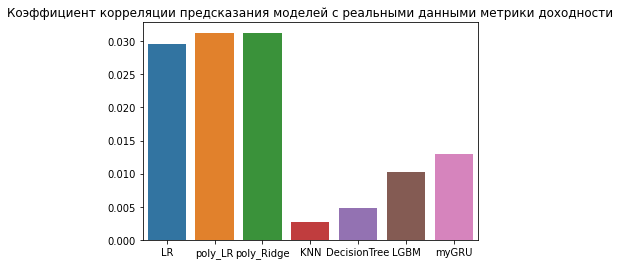

In [ ]:
sns.barplot( x=mod_lists, y=results).set(title = 'Коэффициент корреляции предсказания моделей с реальными данными метрики доходности');

Наиболее эффективной моделью по метрике прогноза доходности в разрезе 15 минут, как требовалось организаторами соревнования, оказалась модель Ridge polynomial Regrssion.

### в т.ч. оценка по скорости

Проверим скорости предсказаний на тестовых данных по лучшим моделям

In [ ]:
%%time
X_test,y_test = split_target(data2_test)
y_test_predict_lr = pipe22.predict(X_test)

CPU times: user 25.4 ms, sys: 997 µs, total: 26.4 ms
Wall time: 25.2 ms


In [ ]:
%%time
y_test_predict_lr_poly = pipe31.predict(X_test)

CPU times: user 141 ms, sys: 42.6 ms, total: 184 ms
Wall time: 179 ms


In [ ]:
%%time
y_test_predict_ridge = pipe122.predict(X_test)

CPU times: user 257 ms, sys: 28.8 ms, total: 286 ms
Wall time: 273 ms


In [ ]:
%%time
y_test_predict_knn = pipe51.predict(X_test)

CPU times: user 1min 47s, sys: 140 ms, total: 1min 47s
Wall time: 1min 48s


In [ ]:
%%time
X_test,y_test = split_target(data1_test)
y_test_predict_dt = pipe41.predict(X_test)

CPU times: user 77.3 ms, sys: 2.01 ms, total: 79.3 ms
Wall time: 78.7 ms


In [ ]:
%%time
y_test_predict_lgb = pipe_lgb.predict(X_test)

CPU times: user 731 ms, sys: 2.79 ms, total: 734 ms
Wall time: 478 ms


In [ ]:
timelines = [26.4,184, 286,108000, 78.7, 478, 90000 ]
timelines_fast = [26.4,184, 286,480, 78.7, 478, 480 ]
res = [i / j for i, j in zip(results, timelines)]

In [ ]:
timelines_per_point = [i/len(X_test) for i in timelines]
timelines_fast_per_point = [i/len(X_test) for i in timelines_fast]

###*

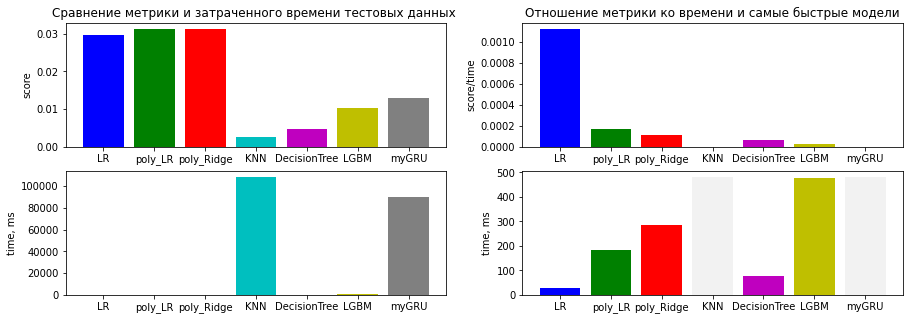

In [ ]:
# на тестовом наборе
fig, axs = plt.subplots(nrows=2 , ncols= 2, figsize=(15,5) )
axs[0,0].bar(range(len(results)), results, tick_label=mod_lists, color=['b', 'g','r','c','m','y','grey'])
axs[1,1].bar(range(len(timelines)), timelines_fast, tick_label=mod_lists, color=['b', 'g','r','0.95','m','y','0.95'])
axs[1,0].bar(range(len(timelines)), timelines, tick_label=mod_lists, color=['b', 'g','r','c','m','y','grey'])
axs[0,1].bar(range(len(timelines)), res, tick_label=mod_lists, color=['b', 'g','r','c','m','y','grey'])
axs[0,0].set(title='Сравнение метрики и затраченного времени тестовых данных ')
axs[0,1].set(title='Отношение метрики ко времени и самые быстрые модели')
axs[0,0].set_ylabel('score')
axs[1,0].set_ylabel('time, ms')
axs[1,1].set_ylabel('time, ms')
axs[0,1].set_ylabel('score/time')
plt.show()

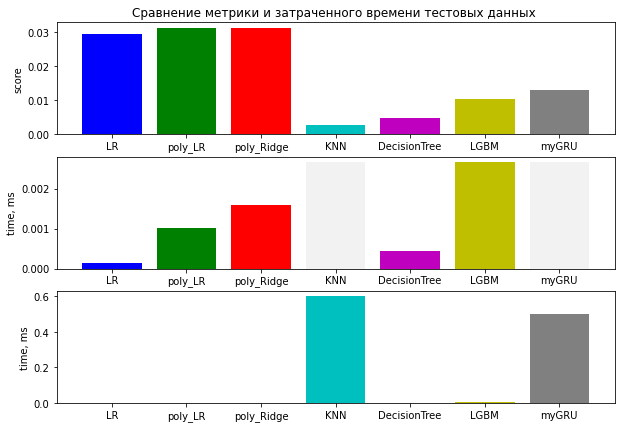

In [ ]:
#на одной точке
fig, axs = plt.subplots(nrows=3 , ncols= 1, figsize=(10,7) )
axs[0].bar(range(len(results)), results, tick_label=mod_lists, color=['b', 'g','r','c','m','y','grey'])
axs[1].bar(range(len(timelines_per_point)), timelines_fast_per_point, tick_label=mod_lists, color=['b', 'g','r','0.95','m','y','0.95'])
axs[2].bar(range(len(timelines_per_point)), timelines_per_point, tick_label=mod_lists, color=['b', 'g','r','c','m','y','grey'])
axs[0].set(title='Сравнение метрики и затраченного времени тестовых данных ')
axs[0].set_ylabel('score')
axs[1].set_ylabel('time, ms')
axs[2].set_ylabel('time, ms')

plt.show()

In [ ]:
pd.DataFrame(zip( results, timelines_per_point), index= mod_lists, columns =[['Метрика качества', 'Время прогноза, мс']])

,Метрика качества,"Время прогноза, мс"
LR,0.029550,0.000147
poly_LR,0.031274,0.001022
poly_Ridge,0.031281,0.001589
KNN,0.002634,0.600053
DecisionTree,0.004804,0.000437
LGBM,0.010246,0.002656
myGRU,0.013022,0.500044


В результате,  наиболее эффективной моделью для предсказания прогноза доходности в разрезе 15 мин, и принимая во внимание скорость предсказаний по тестовым данным, оказывается модель линейной регрессии.
Если появится идея создать бот по прогнозу движения крипто-рынка исходя из заявленного организаторами таргета, то важным элементом становится подбор и тюнинг признаков для линейных регрессионных моделей.
При этом лидеры соревнования достигли оценки 0,0326:  [Доска лидеров](https://www.kaggle.com/competitions/g-research-crypto-forecasting/leaderboard) 
Но в целом, хотелось бы отметить, что расчет таргета в разрезе 15 минут может представлять интерес только для участников рынка, которым не важна цена вхождения в сделку. Организаторы предоставили призовой фонд в $125,000 с пониманием этого факта.

Найдем оценку по всем валютам модели, с наибольшим коэффициентом корреляции,  - это Ridge polynomial Regrssion,  и общую оценку

In [ ]:
def get_weight_asset(asset_id):
    index_value = assets.index[assets['Asset_ID']==asset_id][0]
    w = assets.loc[index_value,'Weight' ]
    weight_array = np.array([w for i in range(len(X_test))])
    return w, weight_array

def get_assets(df_train,df_test, asset_id):
    df_assets_train = df_train[df_train["Asset_ID"] == asset_id]
    df_assets_train = df_assets_train.reindex(range(df_assets_train.index[0],df_assets_train.index[-1]+60,60),method='pad')
    df_assets_test = df_test[df_test["Asset_ID"] == asset_id]
    df_assets_test = df_assets_test.reindex(range(df_assets_test.index[0],df_assets_test.index[-1]+60,60),method='pad')
    
    data_assets_train = get_data2(df_assets_train)
    X_train,y_train = split_target(data_assets_train)
    data_assets_test = get_data2(df_assets_test)
    X_test,y_test = split_target(data_assets_test)
    
    pipe122.fit(X_train,y_train)
    weighted_corr = corr(pipe122.predict(X_test), y_test, weight_array)
    return weighted_corr    

In [ ]:
score =[]
for asset_id, asset_name in zip(assets['Asset_ID'], assets['Asset_Name']):
  score_asset = get_assets(df,df_suppl, asset_id)
  score.append(score_asset)
  print(f" Weighted corr for {asset_name:<16} ID={asset_id:<2} {score_asset:.6f}")
print(f"Mean weighted corr {np.average(score):.6f}")

 Weighted corr for Bitcoin Cash     ID=2  0.111926
 Weighted corr for Binance Coin     ID=0  -0.000164
 Weighted corr for Bitcoin          ID=1  0.031281
 Weighted corr for EOS.IO           ID=5  0.010220
 Weighted corr for Ethereum Classic ID=7  0.034454
 Weighted corr for Ethereum         ID=6  0.006118
 Weighted corr for Litecoin         ID=9  0.023614
 Weighted corr for Monero           ID=11 0.011364
 Weighted corr for TRON             ID=13 0.002733
 Weighted corr for Stellar          ID=12 0.083385
 Weighted corr for Cardano          ID=3  0.018041
 Weighted corr for IOTA             ID=8  0.011995


/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning:

invalid value encountered in log



 Weighted corr for Maker            ID=10 0.008735
 Weighted corr for Dogecoin         ID=4  -0.025442
Mean weighted corr 0.023447


Общий результат по всем валютам :  0,023447

###**

In [ ]:
! pip install shap
import shap